# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from datetime import date
from functools import reduce
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', None)

# Introduction to Deep Learning in Python using TensorFlow and Keras

In this section, we are going to explore the tensorflow package by creating a neural network to determine hand written numbers. We will be using the MNIST data set. This is example is like the "hello world" of deep learning. This activity should help us get familiar with deep learning and how we can apply it to our current project. This example will be using a convolutional neural network (CNN). For our project for predicting games, we will use a multilayer perceptron.

In [2]:
import tensorflow as tf

# Get 28x28 images of handwritten digits 0-9
mnist = tf.keras.datasets.mnist

(X_train, y_train), (X_test, y_test) =  mnist.load_data()

# Normalize our data
X_train = tf.keras.utils.normalize(X_train)
X_test = tf.keras.utils.normalize(X_test)

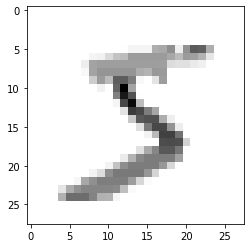

In [3]:
import matplotlib.pyplot as plt

# Show the first image in our training set
plt.imshow(X_train[0], cmap = plt.cm.binary)

plt.show()

In [4]:
# Build the model
model = tf.keras.models.Sequential()

# Add our input layer
model.add(tf.keras.layers.Flatten())

# Add a hidden layers
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))

# Add output layer
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4727 - accuracy: 0.8657
Epoch 2/3
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1158 - accuracy: 0.9647
Epoch 3/3
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0698 - accuracy: 0.9780


In [5]:
validation_loss, validation_accuracy = model.evaluate(X_test, y_test)
print(f"Validation loss: {validation_loss}")
print(f"Validation accuracy: {validation_accuracy}")

313/313 [==============================] - 0s 822us/step - loss: 0.0865 - accuracy: 0.9742
Validation loss: 0.08650635182857513
Validation accuracy: 0.9742000102996826


Consider rewriting this model with the Functional API.
The model's prediction: 7


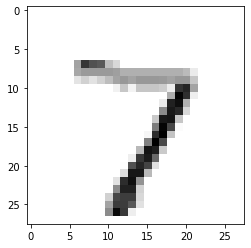

In [6]:
import numpy as np

predictions = model.predict([X_test])
print(f"The model's prediction: {np.argmax(predictions[0])}")

plt.imshow(X_test[0], cmap = plt.cm.binary)
plt.show()

# Loading the Baseball Data

We will start training a neural network using cleaned retrosheet data that we generated when we were training the random forest data. This data has the moving averages for each team over a 10 game span and contains the box score for each game played between the 2014 and 2019 seasons.

In [2]:
dataframe = pd.read_csv("./datasets/cleaned_data/clean_retrosheet.csv")
dataframe.head()

,Date,Number of game,Visiting Team,Home Team,Visiting Team Score,Home Team Score,Home Score SMA,Home Score CMA,Home Score EMA,Home At-bats SMA,Home At-bats CMA,Home At-bats EMA,Home Hits SMA,Home Hits CMA,Home Hits EMA,Home Doubles SMA,Home Doubles CMA,Home Doubles EMA,Home Triples SMA,Home Triples CMA,Home Triples EMA,Home Homeruns SMA,Home Homeruns CMA,Home Homeruns EMA,Home RBIs SMA,Home RBIs CMA,Home RBIs EMA,Home Sacrifice Hits SMA,Home Sacrifice Hits CMA,Home Sacrifice Hits EMA,Home Sacrifice Flies SMA,Home Sacrifice Flies CMA,Home Sacrifice Flies EMA,Home Hit-by-pitch SMA,Home Hit-by-pitch CMA,Home Hit-by-pitch EMA,Home Walks SMA,Home Walks CMA,Home Walks EMA,Home Intentional Walks SMA,Home Intentional Walks CMA,Home Intentional Walks EMA,Home Strikeouts SMA,Home Strikeouts CMA,Home Strikeouts EMA,Home Stolen Bases SMA,Home Stolen Bases CMA,Home Stolen Bases EMA,Home Caught Stealing SMA,Home Caught Stealing CMA,Home Caught Stealing EMA,Home Grounded into DP SMA,Home Grounded into DP CMA,Home Grounded into DP EMA,Home Left on Base SMA,Home Left on Base CMA,Home Left on Base EMA,Home Pitchers Used SMA,Home Pitchers Used CMA,Home Pitchers Used EMA,Home Individual Earned Runs SMA,Home Individual Earned Runs CMA,Home Individual Earned Runs EMA,Home Earned Runs SMA,Home Earned Runs CMA,Home Earned Runs EMA,Home Wild Pitches SMA,Home Wild Pitches CMA,Home Wild Pitches EMA,Home Balks SMA,Home Balks CMA,Home Balks EMA,Home Putouts SMA,Home Putouts CMA,Home Putouts EMA,Home Assists SMA,Home Assists CMA,Home Assists EMA,Home Errors SMA,Home Errors CMA,Home Errors EMA,Home Passed Balls SMA,Home Passed Balls CMA,Home Passed Balls EMA,Home Double Plays SMA,Home Double Plays CMA,Home Double Plays EMA,Home Triple Plays SMA,Home Triple Plays CMA,Home Triple Plays EMA,Visiting Score SMA,Visiting Score CMA,Visiting Score EMA,Visiting At-bats SMA,Visiting At-bats CMA,Visiting At-bats EMA,Visiting Hits SMA,Visiting Hits CMA,Visiting Hits EMA,Visiting Doubles SMA,Visiting Doubles CMA,Visiting Doubles EMA,Visiting Triples SMA,Visiting Triples CMA,Visiting Triples EMA,Visiting Homeruns SMA,Visiting Homeruns CMA,Visiting Homeruns EMA,Visiting RBIs SMA,Visiting RBIs CMA,Visiting RBIs EMA,Visiting Sacrifice Hits SMA,Visiting Sacrifice Hits CMA,Visiting Sacrifice Hits EMA,Visiting Sacrifice Flies SMA,Visiting Sacrifice Flies CMA,Visiting Sacrifice Flies EMA,Visiting Hit-by-pitch SMA,Visiting Hit-by-pitch CMA,Visiting Hit-by-pitch EMA,Visiting Walks SMA,Visiting Walks CMA,Visiting Walks EMA,Visiting Intentional Walks SMA,Visiting Intentional Walks CMA,Visiting Intentional Walks EMA,Visiting Strikeouts SMA,Visiting Strikeouts CMA,Visiting Strikeouts EMA,Visiting Stolen Bases SMA,Visiting Stolen Bases CMA,Visiting Stolen Bases EMA,Visiting Caught Stealing SMA,Visiting Caught Stealing CMA,Visiting Caught Stealing EMA,Visiting Grounded into DP SMA,Visiting Grounded into DP CMA,Visiting Grounded into DP EMA,Visiting Left on Base SMA,Visiting Left on Base CMA,Visiting Left on Base EMA,Visiting Pitchers Used SMA,Visiting Pitchers Used CMA,Visiting Pitchers Used EMA,Visiting Individual Earned Runs SMA,Visiting Individual Earned Runs CMA,Visiting Individual Earned Runs EMA,Visiting Earned Runs SMA,Visiting Earned Runs CMA,Visiting Earned Runs EMA,Visiting Wild Pitches SMA,Visiting Wild Pitches CMA,Visiting Wild Pitches EMA,Visiting Balks SMA,Visiting Balks CMA,Visiting Balks EMA,Visiting Putouts SMA,Visiting Putouts CMA,Visiting Putouts EMA,Visiting Assists SMA,Visiting Assists CMA,Visiting Assists EMA,Visiting Errors SMA,Visiting Errors CMA,Visiting Errors EMA,Visiting Passed Balls SMA,Visiting Passed Balls CMA,Visiting Passed Balls EMA,Visiting Double Plays SMA,Visiting Double Plays CMA,Visiting Double Plays EMA,Visiting Triple Plays SMA,Visiting Triple Plays CMA,Visiting Triple Plays EMA
0,20140415,0,NYN,ARI,9,0,3.8,3.800000,3.430552,34.6,34.600000,34.452952,8.9,8.900000,8.739615,2.0,2.000000,2.081907,0.1,0.100000,0.148760,0.7,0.700000,0.663326,3.7,3.700

Great! We loaded the data from our previously generated csv. Now let's make a "Target" column in our dataset which reflect which team won the game. This will therefore be a binary classification problem since there are onely two outcomes: Home Team Won, Visiting Team Won. We will represent these outcomes as a 0 and 1 respectively.

In [3]:
data = dataframe.copy()

# Create a column indicating which team won
data["Winner"] = np.where(data["Visiting Team Score"] < data["Home Team Score"], 0, 1)

# Add two more columns: runs EMA / earned runs EMA for both teams
data["Visiting Team Runs over Earned Runs EMA"] = data["Visiting Score EMA"] / data["Visiting Earned Runs EMA"]
data["Home Team Runs over Earned Runs EMA"] = data["Home Score EMA"] / data["Home Earned Runs EMA"]

# Drop features and un-used columns that we know won't be useful
data.drop(data.filter(regex="Triple Plays").columns, axis=1, inplace=True)
data.drop(data.filter(regex="Wild Pitches").columns, axis=1, inplace=True)
data.drop(data.filter(regex="Balks").columns, axis=1, inplace=True)
data.drop(data.filter(regex="Passed Balls").columns, axis=1, inplace=True)
data.drop(data.filter(regex="CMA").columns, axis=1, inplace=True)
data.drop(data.filter(regex="SMA").columns, axis=1, inplace=True)
data.drop(columns=["Date",
                   "Number of game",
                   "Visiting Team",
                   "Home Team",
                   "Visiting Team Score",
                   "Home Team Score"],
          inplace=True)

# Split the data into training sets and test sets
train, test = train_test_split(data, test_size=0.25)
train, val = train_test_split(train, test_size=0.2)

assert train.shape[1] == test.shape[1]

print(f"There are {len(train)} training examples")
print(f"There are {len(val)} validation examples")
print(f"There are {len(test)} test examples")

train.head()

There are 8565 training examples
There are 2142 validation examples
There are 3570 test examples


,Home Score EMA,Home At-bats EMA,Home Hits EMA,Home Doubles EMA,Home Triples EMA,Home Homeruns EMA,Home RBIs EMA,Home Sacrifice Hits EMA,Home Sacrifice Flies EMA,Home Hit-by-pitch EMA,Home Walks EMA,Home Intentional Walks EMA,Home Strikeouts EMA,Home Stolen Bases EMA,Home Caught Stealing EMA,Home Grounded into DP EMA,Home Left on Base EMA,Home Pitchers Used EMA,Home Individual Earned Runs EMA,Home Earned Runs EMA,Home Putouts EMA,Home Assists EMA,Home Errors EMA,Home Double Plays EMA,Visiting Score EMA,Visiting At-bats EMA,Visiting Hits EMA,Visiting Doubles EMA,Visiting Triples EMA,Visiting Homeruns EMA,Visiting RBIs EMA,Visiting Sacrifice Hits EMA,Visiting Sacrifice Flies EMA,Visiting Hit-by-pitch EMA,Visiting Walks EMA,Visiting Intentional Walks EMA,Visiting Strikeouts EMA,Visiting Stolen Bases EMA,Visiting Caught Stealing EMA,Visiting Grounded into DP EMA,Visiting Left on Base EMA,Visiting Pitchers Used EMA,Visiting Individual Earned Runs EMA,Visiting Earned Runs EMA,Visiting Putouts EMA,Visiting Assists EMA,Visiting Errors EMA,Visiting Double Plays EMA,Winner,Visiting Team Runs over Earned Runs EMA,Home Team Runs over Earned Runs EMA
185,6.253385,36.569603,10.848798,2.351435,0.024442,0.867623,5.945666,0.304854,0.989475,0.525881,4.427413,0.217573,6.477292,0.707405,0.115945,1.106249,8.631677,4.599335,4.884415,4.884415,29.235093,9.571677,0.165832,0.526296,4.669465,35.685809,9.614309,2.172464,0.047217,0.994317,4.666204,0.212929,0.235831,0.316258,2.253202,0.226668,6.815360,0.585317,0.123999,0.676115,7.015452,4.212196,4.602729,4.602668,25.617275,8.876082,0.684888,0.783509,1,1.014513,1.280273
10719,5.276328,33.943399,9.633871,1.587104,0.140098,1.224799,5.242511,0.023592,0.335781,0.065223,3.867488,0.129784,7.650317,0.346401,0.242927,0.710107,7.132725,5.167612,6.425463,6.425463,27.002596,10.516073,0.365513,0.779835,6.253156,37.172370,10.577706,2.159937,0.317230,1.335334,5.907961,0.058550,0.196337,0.585876,2.739984,0.181253,10.085557,0.097637,0.010437,0.679991,7.648810,4.308426,6.864150,6.864150,25.331675,9.568745,0.357243,1.025180,0,0.910988,0.821159
1500,3.092243,31.191983,7.048629,1.320168,0.327286,0.971723,2.925134,0.536261,0.039896,0.058754,2.463199,0.088327,7.797275,0.408529,0.177432,1.254057,5.039973,3.894228,2.932458,2.932458,27.413679,11.104467,0.803037,0.870471,2.761294,35.910450,7.587092,1.264199,0.239032,0.541896,2.585816,0.652544,0.254544,0.372202,2.745058,0.414694,8.437750,0.319300,0.391501,0.648462,6.900565,4.486399,2.895675,2.895675,28.982870,12.436144,1.079303,1.154251,0,0.953593,1.054488
8549,4.061832,32.629673,7.298749,1.915092,0.007350,1.477827,3.861706,0.028283,0.030449,0.216711,3.393267,0.020471,7.740039,0.028920,0.008974,0.735739,5.956355,4.510846,5.214846,5.214845,27.463409,10.118654,0.508756,0.841114,4.334165,34.283487,8.608721,2.192776,0.179984,0.744577,3.957294,0.228909,0.302098,0.527382,2.582140,0.150953,7.376725,0.574260,0.418817,0.711161,6.099994,3.908351,4.696655,4.696655,25.988499,9.627853,0.382271,0.846326,0,0.922819,0.778898
12284,6.357072,34.677630,8.958836,1.615640,0.250383,1.898946,6.089591,0.148778,0.162658,0.364587,4.148353,0.357044,6.569927,0.554943,0.213236,1.211546,5.950186,5.177861,5.146371,5.146371,28.513621,9.420001,0.427946,0.691062,5.409138,35.058204,9.942256,1.941744,0.022409,1.363379,5.308764,0.373122,0.438942,0.312600,2.641445,0.020003,9.884320,0.748902,0.151767,0.578613,6.416592,4.153354,3.212790,3.212790,26.281380,8.864205,0.469799,0.870240,0,1.683626,1.235253


# Getting the Data Ready for Tensorflow
Now we have our training set and our test set. Before we can train a model, we must first get the dataframe objects properly ready and also correctly identify the feature columns we will be using.

First, we have to wrap the dataframes with `tf.data`, in order to shuffle and batch the data.

In [4]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('Winner')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

We have now created the input pipeline. Let's call it to see the format of the data it returns. For demonstration purposes, we will enter a small batch size to keep the output readable and also only show the first three features.

In [5]:
train_ds = df_to_dataset(train, batch_size=5)

[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys())[:3])
print('A batch of Home Hits EMA:', train_features["Home Score EMA"])
print('A batch of targets:', label_batch )

Every feature: ['Home Score EMA', 'Home At-bats EMA', 'Home Hits EMA']
A batch of Home Hits EMA: tf.Tensor([2.39696238 3.90340843 4.77083252 4.04611816 6.24393228], shape=(5,), dtype=float64)
A batch of targets: tf.Tensor([0 0 1 0 0], shape=(5,), dtype=int32)


In this dataset, all of our features are Numeric. For each Numeric feature, we will have to use a `Normalization()` layer to make sure that the mean of each feature is a 0 and its standard deviation is 1.

In [6]:
# A utility method to create a Normalization Layer
def get_normalization_layer(name, dataset):
    # Create a Normalization layer for our feature.
    normalizer = preprocessing.Normalization()

    # Prepare a Dataset that only yields our feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)

    return normalizer

In [7]:
home_hits_col = train_features["Home Hits EMA"]
layer = get_normalization_layer("Home Hits EMA", train_ds)
layer(home_hits_col)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-1.511351  ],
       [-0.7311694 ],
       [ 0.30083066],
       [-1.2084057 ],
       [ 0.0169687 ]], dtype=float32)>

# Training the Model

We will use the Keras-functional API to build the model since it is more flexible than the tf.keras.Sequential API.

In [8]:
batch_size=64
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [9]:
all_inputs = []
encoded_features = []

for header in tqdm(list(train_features.keys()), unit="feature"):
    numeric_column = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_column = normalization_layer(numeric_column)
    all_inputs.append(numeric_column)
    encoded_features.append(encoded_numeric_column)

In [10]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(64, activation="relu")(all_features)
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.Dense(16, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [11]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
134/134 [==============================] - 9s 36ms/step - loss: 0.7390 - accuracy: 0.5397 - val_loss: 0.6910 - val_accuracy: 0.5359
Epoch 2/10
134/134 [==============================] - 1s 7ms/step - loss: 0.6848 - accuracy: 0.5543 - val_loss: 0.6917 - val_accuracy: 0.5373
Epoch 3/10
134/134 [==============================] - 1s 7ms/step - loss: 0.6850 - accuracy: 0.5384 - val_loss: 0.6919 - val_accuracy: 0.5373
Epoch 4/10
134/134 [==============================] - 2s 10ms/step - loss: 0.6772 - accuracy: 0.5490 - val_loss: 0.6900 - val_accuracy: 0.5364
Epoch 5/10
134/134 [==============================] - 1s 7ms/step - loss: 0.6763 - accuracy: 0.5495 - val_loss: 0.6915 - val_accuracy: 0.5359
Epoch 6/10
134/134 [==============================] - 1s 7ms/step - loss: 0.6752 - accuracy: 0.5552 - val_loss: 0.6916 - val_accuracy: 0.5369
Epoch 7/10
134/134 [==============================] - 1s 7ms/step - loss: 0.6666 - accuracy: 0.5610 - val_loss: 0.6936 - val_accuracy: 0.5378
Epoc

In [12]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

56/56 [==============================] - 0s 5ms/step - loss: 0.7020 - accuracy: 0.5207
Accuracy 0.5207282900810242


In [18]:
# test_dict = test.to_dict("list")
# print(test.iloc[2])

# input_dict = {name: tf.convert_to_tensor([value[2]]) for name, value in test_dict.items()}
# predictions = model.predict(input_dict)
# prob = tf.nn.sigmoid(predictions[0])
# print(float(prob))

# Assessment of the Training

As we can see, the neural network did not do much better than the SVM model or the Random Forrest Classifier. In order to improve this, we will now try training the data on player stats instead. Mickey Mannella parsed the retrosheet event files (which contain play-by-play files for every game) from retrosheet to get all of individual player stats. For the time being, we will not be including the pitcher statistics. This will be added in later. There is a small number of prepatory steps that need to accomplish before training the neural network on this new data.

# Prepping the Data for Round 2

Let's start out by creating a function that simply reads the starting lineups that Mickey generated.

In [13]:
STARTING_LINEUPS_DIR = './datasets/starting_lineups/'

def get_starting_lineups(directory=STARTING_LINEUPS_DIR):
    """Function that returns a dataframe object of all of starting lineups"""
    
    def generate_date(game_id):
        """Helper function that parses a game id for the date"""
        
        # Parse the game_id
        year = int(game_id[3:7])
        month = int(game_id[7:9])
        day = int(game_id[9:11])
        
        return date(year, month, day)
    
    def generate_game_number(game_id):
        """Helper function that parses a game id and returns the game number"""
        return int(game_id[-1])
    
    
    dataframes = []
    for file in os.listdir(directory):
        dataframe = pd.read_csv(os.path.join(directory, file))
        dataframe['Date'] = dataframe.apply(lambda row : generate_date(row['Game ID']), axis=1) 
        dataframe['Game Number'] = dataframe.apply(lambda row : generate_game_number(row['Game ID']), axis=1) 
        dataframes.append(dataframe)

    return pd.concat(dataframes).drop(columns=['Unnamed: 0']).sort_values(by=['Date', 'Game Number'])

In [15]:
get_starting_lineups()

,Game ID,Visiting Team Score,Home Team Score,Visiting Team Player 1 ID,Visiting Team Player 2 ID,Visiting Team Player 3 ID,Visiting Team Player 4 ID,Visiting Team Player 5 ID,Visiting Team Player 6 ID,Visiting Team Player 7 ID,Visiting Team Player 8 ID,Visiting Team Player 9 ID,Visiting Team Starting Pitcher ID,Home Team Player 1 ID,Home Team Player 2 ID,Home Team Player 3 ID,Home Team Player 4 ID,Home Team Player 5 ID,Home Team Player 6 ID,Home Team Player 7 ID,Home Team Player 8 ID,Home Team Player 9 ID,Home Team Starting Pitcher ID,Date,Game Number
0,ARI201403220,3,1,puigy001,turnj001,ramih003,gonza003,vanss001,uribj002,ethia001,ellia001,kersc001,kersc001,polla001,hilla001,goldp001,pradm001,trumm001,montm001,owinc001,parrg001,milew001,milew001,2014-03-22,0
1,ARI201403230,7,5,gordd002,puigy001,ramih003,gonza003,ethia001,ellia001,baxtm001,uribj002,ryu-h001,ryu-h001,polla001,hilla001,goldp001,pradm001,montm001,trumm001,parrg001,gregd001,cahit001,cahit001,2014-03-23,0
2,SDN201403300,1,3,crawc002,puigy001,ramih003,gonza003,ethia001,uribj002,ellia001,gordd002,ryu-h001,ryu-h001,cabre001,denoc001,headc001,gyorj001,alony001,medit001,venaw001,river003,casha001,casha001,2014-03-30,0
3,ANA201403310,10,3,almoa001,millb002,canor001,smoaj001,morrl001,seagk001,saunm001,ackld001,zunim001,hernf002,calhk001,troum001,pujoa001,hamij003,freed001,ibanr001,kendh001,iannc001,aybae001,weavj003,2014-03-31,0
4,BAL201403310,1,2,navad002,pedrd001,ortid001,napom001,carpm001,sizeg001,bogax001,piera001,middw001,lestj001,markn001,hardj003,jonea003,davic003,cruzn002,wietm001,yound003,flahr001,schoj001,tillc001,2014-03-31,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2424,CHA201909290,3,5,reyev001,mercj002,cabrm001,hickj001,rodrr009,stewc002,demet001,greig001,castw003,turns003,sancc001,andet001,abrej003,moncy001,jimee001,collz001,castw002,palkd001,engea001,detwr001,2019-09-29,0
2425,KCA201909290,4,5,wadel001,polaj001,sanom001,cronc002,cavej001,schoj001,castj006,torrr001,milli001,perem004,merrw001,solej001,dozih001,gorda001,mcbrr001,cuthc001,mejie001,arteh001,dinin001,lopej004,2019-09-29,0
2426,SEA201909290,1,3,semim001,profj001,piscs001,davik003,brows003,phegj001,neuss001,barrf001,bolts001,roart001,longs001,crawj002,nolaa002,seagk001,lewik001,narvo001,voged001,smitm007,gordd002,dunnj002,2019-09-29,0
2427,TEX201909290,1,6,lemad001,judga001,gardb001,stanm004,torrg001,sancg002,gregd001,urshg001,maybc001,greec003,choos001,andre001,calhw001,santd001,odorr001,solan001,guzmr001,deshd002,trevj001,lynnl001,2019-09-29,0


Next, let's create a function that get's all of the player statistics that Mickey generated using the retrosheet files. We'll store them in a dictionary so they are easier to access.

In [16]:
PLAYER_BATTING_STATS_DIR = './datasets/player_batting_stats/'

def get_player_batting_stats(directory=PLAYER_BATTING_STATS_DIR):
    """Function returns a dictionary, where each key is a player_id
    and each value is a dataframe object containing the player's stats"""
    
    def generate_date(game_id):
        """Helper function that parses a game id for the date"""
        
        # Parse the game_id
        year = int(game_id[3:7])
        month = int(game_id[7:9])
        day = int(game_id[9:11])
        
        return date(year, month, day)
    
    def generate_game_number(game_id):
        """Helper function that parses a game id and returns the game number"""
        return int(game_id[-1])        
    
    player_stats_dict = dict()
    
    for sub_dir in tqdm(os.listdir(directory), desc='Folder', unit='folders'):
        sub_path = os.path.join(directory, sub_dir)
        for file in tqdm(os.listdir(sub_path), desc='Fetching Batting Stats', unit='players', leave=False):
            dataframe = pd.read_csv(os.path.join(sub_path, file))
            dataframe['Date'] = dataframe.apply(lambda row : generate_date(row['Game ID']), axis=1) 
            dataframe['Game Number'] = dataframe.apply(lambda row : generate_game_number(row['Game ID']), axis=1)
            dataframe.drop(columns=['Unnamed: 0'], inplace=True)
            player_id = dataframe.iloc[0]['ID']
            player_stats_dict[player_id] = dataframe.sort_values(by=['Date', 'Game Number']).reset_index(drop=True)
    
    return player_stats_dict

In [17]:
player_batting_stats_dictionary = get_player_batting_stats()

In [18]:
player_batting_stats_dictionary['judga001'] # Just to see what the dataframe looks like

,Game ID,Hits,Singles,Doubles,Triples,Home Runs,Walks,Bunts,Sacrifice Bunts,Sacrifice Flies,RBIs,At-bats,Stolen Bases,Caught Stealing,Picked Off,Errors,ID,Date,Game Number
0,NYA201608130,2,1,0,0,1,0,0,0,0,1,4,0,0,0,0,judga001,2016-08-13,0
1,NYA201608140,1,0,0,0,1,1,0,0,0,1,3,0,0,0,0,judga001,2016-08-14,0
2,NYA201608150,2,1,1,0,0,1,0,0,0,1,3,0,0,0,0,judga001,2016-08-15,0
3,NYA201608160,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,judga001,2016-08-16,0
4,NYA201608170,2,2,0,0,0,0,0,0,0,1,4,0,0,0,0,judga001,2016-08-17,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,NYA201909220,2,1,0,0,1,0,0,0,0,1,4,0,0,0,0,judga001,2019-09-22,0
390,TBA201909240,1,1,0,0,0,0,0,0,0,0,5,0,0,0,0,judga001,2019-09-24,0
391,TBA201909250,0,0,0,0,0,1,0,0,0,0,3,0,0,0,0,judga001,2019-09-25,0
392,TEX201909280,1,0,0,1,0,0,0,0,0,0,3,0,0,0,0,judga001,2019-09-28,0


Now, we need to generate the statistics using a sliding window. The idea is to capture the player's trend over the specified time period.

In [19]:
def generate_batting_rolling_sums(dictionary, window=10):
    """Function that will generate statsistics based on a rolling window"""
    
    for k, df in tqdm(dictionary.items(), unit='players', desc='Generating Rolling Batter Stats'):
        df = df.copy()
        
        for col in df.columns:
            if col in {'Game ID', 'ID', 'Date', 'Game Number'}:
                continue

            df[f'{col}_{window}_game_window_sum'] = df[col].rolling(window).sum()
            df[f'{col}_{window}_game_window_sum'] = df[f'{col}_{window}_game_window_sum'].shift(1)
        
        # Calculate batting average
        df[f'BA_{window}_game_window'] = (df[f'Hits_{window}_game_window_sum'] /
                                                 df[f'At-bats_{window}_game_window_sum'])
        
        # Calculate on base percentage
        # (Hits + Walks + Hit by Pitch) / (At Bats + Walks + Hit by Pitch + Sacrifice Flies
        df[f'OBP_{window}_game_window'] = ((df[f'Hits_{window}_game_window_sum'] +
                                            df[f'Walks_{window}_game_window_sum']) /
                                           (df[f'At-bats_{window}_game_window_sum'] +
                                            df[f'Walks_{window}_game_window_sum'] +
                                            df[f'Sacrifice Flies_{window}_game_window_sum']))
        
        # Calculate slugging
        # (1B + 2Bx2 + 3Bx3 + HRx4)/AB
        df[f'SLG_{window}_game_window'] = ((df[f'Singles_{window}_game_window_sum'] +
                                            2 * df[f'Doubles_{window}_game_window_sum'] +
                                            3 * df[f'Triples_{window}_game_window_sum'] +
                                            4 * df[f'Home Runs_{window}_game_window_sum']) /
                                           df[f'At-bats_{window}_game_window_sum'])
        
        # Calculate OPS
        df[f'OPS_{window}_game_window'] = (df[f'OBP_{window}_game_window'] +
                                           df[f'SLG_{window}_game_window'])
        
        df.drop(df.loc[:, 'Hits':'Errors'].columns,  axis=1, inplace=True)
        df.dropna(inplace=True)
        
        dictionary[k] = df

In [20]:
player_batting_stats_dictionary_copy = player_batting_stats_dictionary.copy()
generate_batting_rolling_sums(player_batting_stats_dictionary_copy)

In [21]:
player_batting_stats_dictionary_copy['judga001'] # Just to see what the dataframe looks like

,Game ID,ID,Date,Game Number,Hits_10_game_window_sum,Singles_10_game_window_sum,Doubles_10_game_window_sum,Triples_10_game_window_sum,Home Runs_10_game_window_sum,Walks_10_game_window_sum,Bunts_10_game_window_sum,Sacrifice Bunts_10_game_window_sum,Sacrifice Flies_10_game_window_sum,RBIs_10_game_window_sum,At-bats_10_game_window_sum,Stolen Bases_10_game_window_sum,Caught Stealing_10_game_window_sum,Picked Off_10_game_window_sum,Errors_10_game_window_sum,BA_10_game_window,OBP_10_game_window,SLG_10_game_window,OPS_10_game_window
10,NYA201608260,judga001,2016-08-26,0,8.0,5.0,1.0,0.0,2.0,4.0,0.0,0.0,1.0,7.0,36.0,0.0,0.0,0.0,0.0,0.222222,0.292683,0.416667,0.709350
11,NYA201608270,judga001,2016-08-27,0,7.0,4.0,2.0,0.0,1.0,5.0,0.0,0.0,1.0,6.0,35.0,0.0,0.0,0.0,0.0,0.200000,0.292683,0.342857,0.635540
12,NYA201608280,judga001,2016-08-28,0,6.0,4.0,2.0,0.0,0.0,4.0,0.0,0.0,1.0,5.0,33.0,0.0,0.0,0.0,0.0,0.181818,0.263158,0.242424,0.505582
13,KCA201608290,judga001,2016-08-29,0,4.0,3.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,4.0,33.0,0.0,0.0,0.0,0.0,0.121212,0.189189,0.151515,0.340704
14,KCA201608300,judga001,2016-08-30,0,4.0,3.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,4.0,32.0,0.0,0.0,0.0,0.0,0.125000,0.194444,0.156250,0.350694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,NYA201909220,judga001,2019-09-22,0,10.0,3.0,3.0,0.0,4.0,10.0,0.0,0.0,0.0,6.0,33.0,0.0,0.0,0.0,0.0,0.303030,0.465116,0.757576,1.222692
390,TBA201909240,judga001,2019-09-24,0,10.0,3.0,2.0,0.0,5.0,9.0,0.0,0.0,0.0,7.0,33.0,0.0,0.0,0.0,0.0,0.303030,0.452381,0.818182,1.270563
391,TBA201909250,judga001,2019-09-25,0,10.0,3.0,2.0,0.0,5.0,6.0,0.0,0.0,0.0,7.0,36.0,0.0,0.0,0.0,0.0,0.277778,0.380952,0.750000,1.130952
392,TEX201909280,judga001,2019-09-28,0,9.0,3.0,2.0,0.0,4.0,6.0,0.0,0.0,0.0,5.0,35.0,0.0,0.0,0.0,0.0,0.257143,0.365854,0.657143,1.022997


Next, we must do the same thing for pitchers. In particular, get rolling statistics for each pitcher.

In [22]:
PLAYER_PITCHING_STATS_DIR = './datasets/pitcher_stats/'

def get_player_pitching_stats(directory=PLAYER_PITCHING_STATS_DIR):
    """Function returns a dictionary, where each key is a player_id
    and each value is a dataframe object containing the player's stats"""
    
    def generate_date(game_id):
        """Helper function that parses a game id for the date"""
        
        # Parse the game_id
        year = int(game_id[3:7])
        month = int(game_id[7:9])
        day = int(game_id[9:11])
        
        return date(year, month, day)
    
    def generate_game_number(game_id):
        """Helper function that parses a game id and returns the game number"""
        return int(game_id[-1])        
    
    player_stats_dict = dict()
    
    for file in tqdm(os.listdir(PLAYER_PITCHING_STATS_DIR), unit='players', desc='Fetching Pitcher Stats'):
        dataframe = pd.read_csv(os.path.join(PLAYER_PITCHING_STATS_DIR, file))
        dataframe['Date'] = dataframe.apply(lambda row : generate_date(row['Game ID']), axis=1) 
        dataframe['Game Number'] = dataframe.apply(lambda row : generate_game_number(row['Game ID']), axis=1)
        dataframe['ID'] = file[0:-4]
        dataframe.drop(columns=['Unnamed: 0'], inplace=True)
        player_id = dataframe.iloc[0]['ID']
        player_stats_dict[player_id] = dataframe.sort_values(by=['Date', 'Game Number']).reset_index(drop=True)
    
    return player_stats_dict

In [23]:
player_pitching_stats_dictionary = get_player_pitching_stats()

In [24]:
player_pitching_stats_dictionary['kersc001'] # Just to see what the dataframe looks like

,Game ID,ID,Balls,Strikes,Homeruns Allowed,Hits Allowed,Strikeouts,Pickoff Errors,Pickoffs,Wild Pitches,Balks,Walks,Intentional Walks,Hit by Pitch,Earned Runs,Innings Pitched,Date,Game Number
0,ARI201403220,kersc001,28,40,0,5,7,0,0,1,0,1,0,0,1,6.666667,2014-03-22,0
1,WAS201405060,kersc001,21,36,0,9,9,0,1,0,0,0,0,0,0,7.000000,2014-05-06,0
2,LAN201405110,kersc001,26,30,1,7,9,0,0,0,0,0,0,0,3,7.000000,2014-05-11,0
3,ARI201405170,kersc001,20,16,0,6,3,0,0,0,1,2,0,0,6,1.666667,2014-05-17,0
4,PHI201405230,kersc001,30,39,0,2,9,0,0,0,0,3,0,0,0,6.000000,2014-05-23,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,ARI201908310,kersc001,32,33,2,5,6,0,0,0,0,2,0,0,5,5.000000,2019-08-31,0
158,LAN201909060,kersc001,30,33,1,7,6,0,0,0,0,3,0,0,1,4.000000,2019-09-06,0
159,NYN201909130,kersc001,40,32,1,4,5,0,0,0,0,3,0,0,1,6.333333,2019-09-13,0
160,LAN201909200,kersc001,32,37,3,8,5,0,0,0,0,1,0,0,4,6.000000,2019-09-20,0


We will now get the rolling sums of the statistics for the pitchers.

In [25]:
def generate_pitching_rolling_sums(dictionary, window=10):
    """Function that will generate statsistics based on a rolling window"""
    
    for k, df in tqdm(dictionary.items(), unit='players', desc='Generating Rolling Pitcher Stats'):
        df = df.copy()
        
        for col in df.columns:
            if col in {'Game ID', 'ID', 'Date', 'Game Number'}:
                continue

            df[f'{col}_{window}_game_window_sum'] = df[col].rolling(window).sum()
            df[f'{col}_{window}_game_window_sum'] = df[f'{col}_{window}_game_window_sum'].shift(1)
        
        # Calculate ERA
        df[f'ERA_{window}_game_window'] = ((df[f'Earned Runs_{window}_game_window_sum'] * 9) /
                                           df[f'Innings Pitched_{window}_game_window_sum'])
        
        # Calculate WHIP
        # (Walks + hits) / innings pitched
        df[f'WHIP_{window}_game_window'] = ((df[f'Hits Allowed_{window}_game_window_sum'] +
                                             df[f'Walks_{window}_game_window_sum']) /
                                            (df[f'Innings Pitched_{window}_game_window_sum']))
        
        # Calculate FIP
        # (13 * HR + 3*(BB + HBP) - 2*K) / IP + constant
        df[f'FIP_{window}_game_window'] = (((13 * df[f'Homeruns Allowed_{window}_game_window_sum']) +
                                             (3 * (df[f'Walks_{window}_game_window_sum'] +
                                                   df[f'Hit by Pitch_{window}_game_window_sum'])) -
                                             (2 * df[f'Strikeouts_{window}_game_window_sum'])) /
                                            (df[f'Innings Pitched_{window}_game_window_sum'])) + 3.2
        
        df.drop(df.loc[:, 'Balls':'Innings Pitched'].columns,  axis=1, inplace=True)
        df.dropna(inplace=True)
        
        dictionary[k] = df

In [26]:
player_pitching_stats_dictionary_copy = player_pitching_stats_dictionary.copy()
generate_pitching_rolling_sums(player_pitching_stats_dictionary_copy)

In [27]:
player_pitching_stats_dictionary_copy['kersc001'] # Just to see what the dataframe looks like

,Game ID,ID,Date,Game Number,Balls_10_game_window_sum,Strikes_10_game_window_sum,Homeruns Allowed_10_game_window_sum,Hits Allowed_10_game_window_sum,Strikeouts_10_game_window_sum,Pickoff Errors_10_game_window_sum,Pickoffs_10_game_window_sum,Wild Pitches_10_game_window_sum,Balks_10_game_window_sum,Walks_10_game_window_sum,Intentional Walks_10_game_window_sum,Hit by Pitch_10_game_window_sum,Earned Runs_10_game_window_sum,Innings Pitched_10_game_window_sum,ERA_10_game_window,WHIP_10_game_window,FIP_10_game_window
10,KCA201406240,kersc001,2014-06-24,0,268.0,350.0,4.0,51.0,86.0,0.0,1.0,3.0,1.0,8.0,0.0,0.0,17.0,64.333333,2.378238,0.917098,1.707772
11,LAN201406290,kersc001,2014-06-29,0,277.0,346.0,4.0,52.0,87.0,0.0,1.0,3.0,1.0,8.0,0.0,0.0,16.0,65.666667,2.192893,0.913706,1.707614
12,COL201407040,kersc001,2014-07-04,0,289.0,350.0,4.0,48.0,91.0,0.0,0.0,3.0,1.0,10.0,0.0,0.0,16.0,65.666667,2.192893,0.883249,1.677157
13,LAN201407100,kersc001,2014-07-10,0,288.0,353.0,3.0,43.0,90.0,0.0,1.0,3.0,1.0,11.0,0.0,0.0,13.0,66.666667,1.755000,0.810000,1.580000
14,SLN201407200,kersc001,2014-07-20,0,297.0,379.0,4.0,40.0,98.0,0.0,1.0,3.0,0.0,10.0,0.0,0.0,8.0,74.000000,0.972973,0.675676,1.659459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,ARI201908310,kersc001,2019-08-31,0,280.0,332.0,9.0,43.0,84.0,0.0,0.0,5.0,1.0,16.0,0.0,2.0,17.0,65.000000,2.353846,0.907692,3.246154
158,LAN201909060,kersc001,2019-09-06,0,287.0,333.0,10.0,41.0,83.0,0.0,0.0,5.0,1.0,18.0,0.0,2.0,18.0,63.000000,2.571429,0.936508,3.580952
159,NYN201909130,kersc001,2019-09-13,0,291.0,332.0,11.0,43.0,80.0,0.0,0.0,5.0,1.0,20.0,0.0,1.0,18.0,60.000000,2.700000,1.050000,3.966667
160,LAN201909200,kersc001,2019-09-20,0,300.0,331.0,11.0,43.0,78.0,0.0,0.0,3.0,1.0,21.0,0.0,1.0,18.0,60.333333,2.685083,1.060773,4.078453


Next, we need to merge the starting lineup dataframe with the each of the player's stats.

In [28]:
def merge_starting_lineup_with_stats(starting_lineup,
                                     player_batting_stats_dict,
                                     player_pitching_stats_dict):
    """Get the starting lineups with the stats of each player"""
    
    def batter_stats_df(player_batting_stats_dict):
        """Function to make one dataframe for all players"""
        
        dfs = []
        for _, v in player_batting_stats_dict.items():
            dfs.append(v)

        return pd.concat(dfs, ignore_index=True).sort_values(by=['Date', 'Game Number'])
    
    def pitcher_stats_df(player_pitching_stats_dict):
        """Function to make one dataframe for all players"""
        
        dfs = []
        for _, v in player_pitching_stats_dict.items():
            dfs.append(v)

        return pd.concat(dfs, ignore_index=True).sort_values(by=['Date', 'Game Number'])

    # Get a dataframe for just the player's stats
    batters_df = batter_stats_df(player_batting_stats_dict)
    pitchers_df = pitcher_stats_df(player_pitching_stats_dict)
    
    # Need to make new columns for each player
    dfs = []
    for col in tqdm(starting_lineup.columns, unit='columns', desc='Creating Trainable Data'):
        if col in {'Game ID', 'ID', 'Date', 'Game Number', 'Visiting Team Score', 'Home Team Score'}:
            continue
        if col in {'Home Team Starting Pitcher ID', 'Visiting Team Starting Pitcher ID'}:
            df = pd.merge(starting_lineup,
                          pitchers_df,
                          how='left',
                          left_on=['Game ID', 'Date', 'Game Number', col],
                          right_on=['Game ID', 'Date', 'Game Number', 'ID'])
        else:            
            df = pd.merge(starting_lineup,
                          batters_df,
                          how='left',
                          left_on=['Game ID', 'Date', 'Game Number', col],
                          right_on=['Game ID', 'Date', 'Game Number', 'ID'])
        
        df.drop(columns=['ID'], inplace=True)
        df.columns = list(df.columns[0:25]) + [f'{col[:-3]}_{string}' for string in df.columns[25::]]
        dfs.append(df)
    
    df_merged = reduce(lambda left, right: pd.merge(left,
                                                    right,
                                                    how='left',
                                                    left_on=list(left.columns[0:25]),
                                                    right_on=list(right.columns[0:25])),
                       dfs)
    return df_merged.dropna().sort_values(by=['Date', 'Game Number'])

In [29]:
round_2_data = merge_starting_lineup_with_stats(get_starting_lineups(),
                                                player_batting_stats_dictionary_copy,
                                                player_pitching_stats_dictionary_copy).dropna()

In [ ]:
def add_features

# Training for Round 2

Now, we can try retraining a neural network model on the data we just generated.

In [35]:
round_2_data

,Game ID,Visiting Team Score,Home Team Score,Visiting Team Player 1 ID,Visiting Team Player 2 ID,Visiting Team Player 3 ID,Visiting Team Player 4 ID,Visiting Team Player 5 ID,Visiting Team Player 6 ID,Visiting Team Player 7 ID,Visiting Team Player 8 ID,Visiting Team Player 9 ID,Visiting Team Starting Pitcher ID,Home Team Player 1 ID,Home Team Player 2 ID,Home Team Player 3 ID,Home Team Player 4 ID,Home Team Player 5 ID,Home Team Player 6 ID,Home Team Player 7 ID,Home Team Player 8 ID,Home Team Player 9 ID,Home Team Starting Pitcher ID,Date,Game Number,Visiting Team Player 1_Hits_10_game_window_sum,Visiting Team Player 1_Singles_10_game_window_sum,Visiting Team Player 1_Doubles_10_game_window_sum,Visiting Team Player 1_Triples_10_game_window_sum,Visiting Team Player 1_Home Runs_10_game_window_sum,Visiting Team Player 1_Walks_10_game_window_sum,Visiting Team Player 1_Bunts_10_game_window_sum,Visiting Team Player 1_Sacrifice Bunts_10_game_window_sum,Visiting Team Player 1_Sacrifice Flies_10_game_window_sum,Visiting Team Player 1_RBIs_10_game_window_sum,Visiting Team Player 1_At-bats_10_game_window_sum,Visiting Team Player 1_Stolen Bases_10_game_window_sum,Visiting Team Player 1_Caught Stealing_10_game_window_sum,Visiting Team Player 1_Picked Off_10_game_window_sum,Visiting Team Player 1_Errors_10_game_window_sum,Visiting Team Player 1_BA_10_game_window,Visiting Team Player 1_OBP_10_game_window,Visiting Team Player 1_SLG_10_game_window,Visiting Team Player 1_OPS_10_game_window,Visiting Team Player 2_Hits_10_game_window_sum,Visiting Team Player 2_Singles_10_game_window_sum,Visiting Team Player 2_Doubles_10_game_window_sum,Visiting Team Player 2_Triples_10_game_window_sum,Visiting Team Player 2_Home Runs_10_game_window_sum,Visiting Team Player 2_Walks_10_game_window_sum,Visiting Team Player 2_Bunts_10_game_window_sum,Visiting Team Player 2_Sacrifice Bunts_10_game_window_sum,Visiting Team Player 2_Sacrifice Flies_10_game_window_sum,Visiting Team Player 2_RBIs_10_game_window_sum,Visiting Team Player 2_At-bats_10_game_window_sum,Visiting Team Player 2_Stolen Bases_10_game_window_sum,Visiting Team Player 2_Caught Stealing_10_game_window_sum,Visiting Team Player 2_Picked Off_10_game_window_sum,Visiting Team Player 2_Errors_10_game_window_sum,Visiting Team Player 2_BA_10_game_window,Visiting Team Player 2_OBP_10_game_window,Visiting Team Player 2_SLG_10_game_window,Visiting Team Player 2_OPS_10_game_window,Visiting Team Player 3_Hits_10_game_window_sum,Visiting Team Player 3_Singles_10_game_window_sum,Visiting Team Player 3_Doubles_10_game_window_sum,Visiting Team Player 3_Triples_10_game_window_sum,Visiting Team Player 3_Home Runs_10_game_window_sum,Visiting Team Player 3_Walks_10_game_window_sum,Visiting Team Player 3_Bunts_10_game_window_sum,Visiting Team Player 3_Sacrifice Bunts_10_game_window_sum,Visiting Team Player 3_Sacrifice Flies_10_game_window_sum,Visiting Team Player 3_RBIs_10_game_window_sum,Visiting Team Player 3_At-bats_10_game_window_sum,Visiting Team Player 3_Stolen Bases_10_game_window_sum,Visiting Team Player 3_Caught Stealing_10_game_window_sum,Visiting Team Player 3_Picked Off_10_game_window_sum,Visiting Team Player 3_Errors_10_game_window_sum,Visiting Team Player 3_BA_10_game_window,Visiting Team Player 3_OBP_10_game_window,Visiting Team Player 3_SLG_10_game_window,Visiting Team Player 3_OPS_10_game_window,Visiting Team Player 4_Hits_10_game_window_sum,Visiting Team Player 4_Singles_10_game_window_sum,Visiting Team Player 4_Doubles_10_game_window_sum,Visiting Team Player 4_Triples_10_game_window_sum,Visiting Team Player 4_Home Runs_10_game_window_sum,Visiting Team Player 4_Walks_10_game_window_sum,Visiting Team Player 4_Bunts_10_game_window_sum,Visiting Team Player 4_Sacrifice Bunts_10_game_window_sum,Visiting Team Player 4_Sacrifice Flies_10_game_window_sum,Visiting Team Player 4_RBIs_10_game_window_sum,Visiting Team Player 4_At-bats_10_game_window_sum,Visiting Team Player 4_Stolen Bases_10_game_window_sum,Visiting 

In [36]:
def create_nn_with_player_data(batch_size=64,
                               test_size=.2,
                               val_size=.2,
                               epochs=10,
                               batter_window=10,
                               pitcher_window=10):
    
    # Get the stats
    batting_dict = get_player_batting_stats()
    pitching_dict = get_player_pitching_stats()
    
    # Get the rolling sums based on the window size
    generate_batting_rolling_sums(batting_dict, batter_window)
    generate_pitching_rolling_sums(pitching_dict, pitcher_window)
    
    # Merge the data with the starting linups
    data = merge_starting_lineup_with_stats(get_starting_lineups(),
                                            batting_dict,
                                            pitching_dict)
    
    # Create target label
    data['Winner'] = np.where(data['Visiting Team Score'] < data['Home Team Score'], 0 , 1)
    data.drop(columns=data.columns[0:25], inplace=True)
    
    # Split the data into training sets and test sets
    train, test = train_test_split(data, test_size=test_size)
    train, val = train_test_split(train, test_size=val_size)
    
    assert train.shape[1] == test.shape[1]
    
    # Create tf.data datasets
    train_ds = df_to_dataset(train, batch_size=batch_size)
    val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
    test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)
    
    # Inputs
    all_inputs = []
    encoded_features = []
    
    # Get features and label batch
    [(train_features, label_batch)] = train_ds.take(1)
    
    # Normalize feature vectors
    for header in tqdm(list(train_features.keys()), unit="feature", desc='Normalizing Features'):
        numeric_column = tf.keras.Input(shape=(1,), name=header)
        normalization_layer = get_normalization_layer(header, train_ds)
        encoded_numeric_column = normalization_layer(numeric_column)
        all_inputs.append(numeric_column)
        encoded_features.append(encoded_numeric_column)
        
    # Create network
    all_features = tf.keras.layers.concatenate(encoded_features)
    x = tf.keras.layers.Dense(64, activation="relu")(all_features)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.Dropout(.5)(x)
    output = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(all_inputs, output)
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=["accuracy"])
    
    # Fit the model
    model.fit(train_ds, epochs=epochs, validation_data=val_ds)
    
    # Assess model
    loss, accuracy = model.evaluate(test_ds)
    print("Accuracy of model on test dataset", accuracy)
    
    return model

In [37]:
create_nn_with_player_data(batch_size=64,
                           test_size=.2,
                           val_size=.2,
                           epochs=4,
                           batter_window=5,
                           pitcher_window=5)


Epoch 1/4
95/95 [==============================] - 17s 70ms/step - loss: 0.7169 - accuracy: 0.5198 - val_loss: 0.6929 - val_accuracy: 0.5252
Epoch 2/4
95/95 [==============================] - 2s 18ms/step - loss: 0.6775 - accuracy: 0.5604 - val_loss: 0.6884 - val_accuracy: 0.5318
Epoch 3/4
95/95 [==============================] - 2s 19ms/step - loss: 0.6602 - accuracy: 0.6041 - val_loss: 0.6924 - val_accuracy: 0.5411
Epoch 4/4
30/30 [==============================] - 1s 16ms/step - loss: 0.7026 - accuracy: 0.5385
Accuracy of model on test dataset 0.5384615659713745


In [38]:
create_nn_with_player_data(batch_size=64,
                           test_size=.2,
                           val_size=.2,
                           epochs=4,
                           batter_window=10,
                           pitcher_window=5)


Epoch 1/4
74/74 [==============================] - 17s 99ms/step - loss: 0.7140 - accuracy: 0.5272 - val_loss: 0.6934 - val_accuracy: 0.5145
Epoch 2/4
74/74 [==============================] - 2s 18ms/step - loss: 0.6763 - accuracy: 0.5799 - val_loss: 0.6977 - val_accuracy: 0.5188
Epoch 3/4
74/74 [==============================] - 2s 20ms/step - loss: 0.6421 - accuracy: 0.6375 - val_loss: 0.7105 - val_accuracy: 0.5265
Epoch 4/4
23/23 [==============================] - 0s 13ms/step - loss: 0.7111 - accuracy: 0.5338
Accuracy of model on test dataset 0.5338345766067505


In [39]:
create_nn_with_player_data(batch_size=64,
                           test_size=.2,
                           val_size=.2,
                           epochs=4,
                           batter_window=7,
                           pitcher_window=7)


Epoch 1/4
83/83 [==============================] - 19s 95ms/step - loss: 0.7232 - accuracy: 0.5107 - val_loss: 0.6931 - val_accuracy: 0.5308
Epoch 2/4
83/83 [==============================] - 2s 19ms/step - loss: 0.6799 - accuracy: 0.5526 - val_loss: 0.6934 - val_accuracy: 0.5255
Epoch 3/4
83/83 [==============================] - 2s 20ms/step - loss: 0.6511 - accuracy: 0.6259 - val_loss: 0.7034 - val_accuracy: 0.5270
Epoch 4/4
26/26 [==============================] - 0s 14ms/step - loss: 0.7126 - accuracy: 0.5362
Accuracy of model on test dataset 0.5362142324447632


In [40]:
data_2 = round_2_data.copy()

# Create a new column labeled winner
data_2["Winner"] = np.where(data_2["Visiting Team Score"] < data_2["Home Team Score"], 0, 1)

# Drop the columns that will not be useful
data_2.drop(columns=data_2.columns[0:25], inplace=True)
data_2

# Split the data into training sets and test sets
train_2, test_2 = train_test_split(data_2, test_size=0.25)
train_2, val_2 = train_test_split(train_2, test_size=0.2)

assert train.shape[1] == test.shape[1]

print(f"There are {len(train_2)} training examples")
print(f"There are {len(val_2)} validation examples")
print(f"There are {len(test_2)} test examples")

train_2

There are 4045 training examples
There are 1012 validation examples
There are 1686 test examples


,Visiting Team Player 1_Hits_10_game_window_sum,Visiting Team Player 1_Singles_10_game_window_sum,Visiting Team Player 1_Doubles_10_game_window_sum,Visiting Team Player 1_Triples_10_game_window_sum,Visiting Team Player 1_Home Runs_10_game_window_sum,Visiting Team Player 1_Walks_10_game_window_sum,Visiting Team Player 1_Bunts_10_game_window_sum,Visiting Team Player 1_Sacrifice Bunts_10_game_window_sum,Visiting Team Player 1_Sacrifice Flies_10_game_window_sum,Visiting Team Player 1_RBIs_10_game_window_sum,Visiting Team Player 1_At-bats_10_game_window_sum,Visiting Team Player 1_Stolen Bases_10_game_window_sum,Visiting Team Player 1_Caught Stealing_10_game_window_sum,Visiting Team Player 1_Picked Off_10_game_window_sum,Visiting Team Player 1_Errors_10_game_window_sum,Visiting Team Player 1_BA_10_game_window,Visiting Team Player 1_OBP_10_game_window,Visiting Team Player 1_SLG_10_game_window,Visiting Team Player 1_OPS_10_game_window,Visiting Team Player 2_Hits_10_game_window_sum,Visiting Team Player 2_Singles_10_game_window_sum,Visiting Team Player 2_Doubles_10_game_window_sum,Visiting Team Player 2_Triples_10_game_window_sum,Visiting Team Player 2_Home Runs_10_game_window_sum,Visiting Team Player 2_Walks_10_game_window_sum,Visiting Team Player 2_Bunts_10_game_window_sum,Visiting Team Player 2_Sacrifice Bunts_10_game_window_sum,Visiting Team Player 2_Sacrifice Flies_10_game_window_sum,Visiting Team Player 2_RBIs_10_game_window_sum,Visiting Team Player 2_At-bats_10_game_window_sum,Visiting Team Player 2_Stolen Bases_10_game_window_sum,Visiting Team Player 2_Caught Stealing_10_game_window_sum,Visiting Team Player 2_Picked Off_10_game_window_sum,Visiting Team Player 2_Errors_10_game_window_sum,Visiting Team Player 2_BA_10_game_window,Visiting Team Player 2_OBP_10_game_window,Visiting Team Player 2_SLG_10_game_window,Visiting Team Player 2_OPS_10_game_window,Visiting Team Player 3_Hits_10_game_window_sum,Visiting Team Player 3_Singles_10_game_window_sum,Visiting Team Player 3_Doubles_10_game_window_sum,Visiting Team Player 3_Triples_10_game_window_sum,Visiting Team Player 3_Home Runs_10_game_window_sum,Visiting Team Player 3_Walks_10_game_window_sum,Visiting Team Player 3_Bunts_10_game_window_sum,Visiting Team Player 3_Sacrifice Bunts_10_game_window_sum,Visiting Team Player 3_Sacrifice Flies_10_game_window_sum,Visiting Team Player 3_RBIs_10_game_window_sum,Visiting Team Player 3_At-bats_10_game_window_sum,Visiting Team Player 3_Stolen Bases_10_game_window_sum,Visiting Team Player 3_Caught Stealing_10_game_window_sum,Visiting Team Player 3_Picked Off_10_game_window_sum,Visiting Team Player 3_Errors_10_game_window_sum,Visiting Team Player 3_BA_10_game_window,Visiting Team Player 3_OBP_10_game_window,Visiting Team Player 3_SLG_10_game_window,Visiting Team Player 3_OPS_10_game_window,Visiting Team Player 4_Hits_10_game_window_sum,Visiting Team Player 4_Singles_10_game_window_sum,Visiting Team Player 4_Doubles_10_game_window_sum,Visiting Team Player 4_Triples_10_game_window_sum,Visiting Team Player 4_Home Runs_10_game_window_sum,Visiting Team Player 4_Walks_10_game_window_sum,Visiting Team Player 4_Bunts_10_game_window_sum,Visiting Team Player 4_Sacrifice Bunts_10_game_window_sum,Visiting Team Player 4_Sacrifice Flies_10_game_window_sum,Visiting Team Player 4_RBIs_10_game_window_sum,Visiting Team Player 4_At-bats_10_game_window_sum,Visiting Team Player 4_Stolen Bases_10_game_window_sum,Visiting Team Player 4_Caught Stealing_10_game_window_sum,Visiting Team Player 4_Picked Off_10_game_window_sum,Visiting Team Player 4_Errors_10_game_window_sum,Visiting Team Player 4_BA_10_game_window,Visiting Team Player 4_OBP_10_game_window,Visiting Team Player 4_SLG_10_game_window,Visiting Team Player 4_OPS_10_game_window,Visiting Team Player 5_Hits_10_game_window_sum,Visiting Team Player 5_Singles_10_game_window_sum,Visiting Team Player 5_Doubles_10_game_window_sum,Visiting Team Player 5_Triples_10_game_window_sum,Visiting Team Player 5_Home Runs_10_game_w

In [41]:
batch_size=64
train_2_ds = df_to_dataset(train_2, batch_size=batch_size)
val_2_ds = df_to_dataset(val_2, shuffle=False, batch_size=batch_size)
test_2_ds = df_to_dataset(test_2, shuffle=False, batch_size=batch_size)

In [42]:
all_inputs_2 = []
encoded_features_2 = []

[(train_features_2, label_batch_2)] = train_2_ds.take(1)

for header in tqdm(list(train_features_2.keys()), unit="feature"):
    numeric_column = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_2_ds)
    encoded_numeric_column = normalization_layer(numeric_column)
    all_inputs_2.append(numeric_column)
    encoded_features_2.append(encoded_numeric_column)

In [43]:
all_features_2 = tf.keras.layers.concatenate(encoded_features_2)
x_2 = tf.keras.layers.Dense(64, activation="relu")(all_features_2)
x_2 = tf.keras.layers.Dense(64, activation="relu")(x_2)
x_2 = tf.keras.layers.Dense(64, activation="relu")(x_2)
x_2 = tf.keras.layers.Dropout(.5)(x_2)
output_2 = tf.keras.layers.Dense(1, activation="sigmoid")(x_2)
model_2 = tf.keras.Model(all_inputs_2, output_2)
model_2.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=["accuracy"])

In [44]:
model_2.fit(train_2_ds, epochs=4, validation_data=val_2_ds)

Epoch 1/4
64/64 [==============================] - 18s 103ms/step - loss: 0.7700 - accuracy: 0.4991 - val_loss: 0.6953 - val_accuracy: 0.5336
Epoch 2/4
64/64 [==============================] - 2s 21ms/step - loss: 0.6821 - accuracy: 0.5794 - val_loss: 0.6940 - val_accuracy: 0.5296
Epoch 3/4
64/64 [==============================] - 2s 22ms/step - loss: 0.6545 - accuracy: 0.6216 - val_loss: 0.6984 - val_accuracy: 0.5405
Epoch 4/4
64/64 [==============================] - 2s 22ms/step - loss: 0.6244 - accuracy: 0.6654 - val_loss: 0.7123 - val_accuracy: 0.5227


In [45]:
loss_2, accuracy_2 = model_2.evaluate(test_2_ds)
print("Accuracy", accuracy_2)

27/27 [==============================] - 1s 17ms/step - loss: 0.7001 - accuracy: 0.5516
Accuracy 0.5516014099121094


# Assesment of Round 2
Unfortunately, adding the team data (even though it does not have the pitching statistics), did not make much of an improvement. The loss remained quite hight for the second model on the test set and the accuracy was again around 55%. Next, we will now try to leverage convolutional neural networks.

# Round 3: Convolutional Neural Networks
We are now going to try training the data on a convolutional neural network. Normally, CNNs are used in image processing and is a very powerful model. Each matchup, i.e. a game between two teams, will be a training point and each training point will have a matrix associated with it. This matrix will contain the outcomes for both teams over the last 10 games. We will treat this matrix as an image and hopefully, this can lead to some promising results.
<img src="./images/convnet_image.png" alt="Matrix Datapoint" style="width: 450;"/>
Above is a visual depiction of how a training point will be represented.

# Prepping the Data for Convnet

In [46]:
def get_all_game_box_scores(team_stats_dir='./datasets/team_stats/'):
    """Function to get all box scores
    
    Returns a dictionary where each key is a team abbreviation and the value is
    a dataframe object of their games stats"""

    team_games = dict()
    for file in os.listdir(team_stats_dir):
        team_abbrev = file[0:3]
        df = pd.read_csv(os.path.join(team_stats_dir,
                                      file)).sort_values(by=['Date', 'Number of game'])
        
        # Add batting average
        df['Batting Average'] = df['Hits'] / df['At-bats']
        
        # Add on base percentage
        # OBP = (Hits + Walks + Hit by Pitch) / (At Bats + Walks + Hit by Pitch + Sacrifice Flies)
        df['On Base Percentage'] = ((df['Hits'] + df['Walks'] + df['Hit-by-pitch']) /
                                    (df['At-bats'] + df['Walks'] + df['Hit-by-pitch'] + df['Sacrifice Flies']))
        
        # Add slugging
        # SLG = (1B + 2Bx2 + 3Bx3 + HRx4)/AB.
        df['Slugging'] = ((df['Hits']-df['Doubles']-df['Triples']-df['Homeruns']) +
                          2*df['Doubles'] +
                          3*df['Triples'] +
                          4*df['Homeruns']) / df['At-bats']
        
        # Drop unnecessary fields
        df.drop(columns=['Triple Plays'], inplace=True)
        df.drop(columns=['Wild Pitches'], inplace=True)
        df.drop(columns=['Balks'], inplace=True)
        
        team_games[team_abbrev] = df.reset_index(drop=True)

    return team_games

In [47]:
get_all_game_box_scores()['NYA']

,Date,Number of game,Team,League,Game Number,Score,At-bats,Hits,Doubles,Triples,Homeruns,RBIs,Sacrifice Hits,Sacrifice Flies,Hit-by-pitch,Walks,Intentional Walks,Strikeouts,Stolen Bases,Caught Stealing,Grounded into DP,Left on Base,Pitchers Used,Individual Earned Runs,Earned Runs,Putouts,Assists,Errors,Passed Balls,Double Plays,Batting Average,On Base Percentage,Slugging
0,20140401,0,NYA,AL,1,2,32,6,1,0,0,2,0,0,2,3,0,3,0,0,1,8,3,6,6,24,11,1,0,1,0.187500,0.297297,0.218750
1,20140402,0,NYA,AL,2,1,33,7,1,0,0,0,0,0,0,3,0,10,1,0,1,8,4,3,3,24,10,1,0,1,0.212121,0.277778,0.242424
2,20140403,0,NYA,AL,3,4,32,7,2,0,0,4,0,1,0,4,0,9,0,0,0,6,4,2,2,27,13,0,0,4,0.218750,0.297297,0.281250
3,20140404,0,NYA,AL,4,7,40,16,4,1,0,7,1,0,0,4,1,10,4,0,0,11,4,2,2,27,11,1,0,1,0.400000,0.454545,0.550000
4,20140405,0,NYA,AL,5,0,32,7,1,0,0,0,0,0,2,3,0,9,0,0,1,10,3,4,4,24,9,0,0,0,0.218750,0.324324,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,20190924,0,NYA,AL,158,1,43,7,1,0,1,1,0,0,1,1,0,13,0,0,0,8,11,2,2,33,11,0,0,1,0.162791,0.200000,0.255814
968,20190925,0,NYA,AL,159,0,27,1,0,0,0,0,0,0,0,5,0,16,0,0,1,5,7,4,4,24,7,1,0,0,0.037037,0.187500,0.037037
969,20190927,0,NYA,AL,160,14,42,18,4,0,6,14,0,0,0,5,0,11,0,0,3,6,9,6,6,27,6,1,0,1,0.428571,0.489362,0.952381
970,20190928,0,NYA,AL,161,4,30,7,1,1,0,4,0,1,1,2,0,7,0,0,3,3,7,9,9,24,6,2,0,0,0.233333,0.294118,0.333333


In [48]:
def get_schedule(year_gls_dir='./datasets/retro_sheet_gls/'):
    """Function to return the game schedule
    
    Returns a dataframe object"""
    
    dfs = []
    for file in os.listdir(year_gls_dir):
        df = pd.read_csv(os.path.join(year_gls_dir, file))
        df['Game ID'] = df['Home Team'].str.cat(df['Date'].astype('string').str.cat(df['Number of game'].astype('string')))
        df['Winner'] = np.where(df['Home Team Score'] > df['Visiting Team Score'], 1, 0)
        df = df.filter(items=['Game ID',
                         'Date',
                         'Number of game',
                         'Visiting Team',
                         'Home Team',
                         'Visiting Team Score',
                         'Home Team Score',
                         'Winner'],
                       axis=1)
        dfs.append(df)
    
    return pd.concat(dfs).sort_values(by=['Date', 'Number of game']).reset_index(drop=True)

In [49]:
get_schedule()

,Game ID,Date,Number of game,Visiting Team,Home Team,Visiting Team Score,Home Team Score,Winner
0,ARI201403220,20140322,0,LAN,ARI,3,1,0
1,ARI201403230,20140323,0,LAN,ARI,7,5,0
2,SDN201403300,20140330,0,LAN,SDN,1,3,1
3,ANA201403310,20140331,0,SEA,ANA,10,3,0
4,BAL201403310,20140331,0,BOS,BAL,1,2,1
...,...,...,...,...,...,...,...,...
14572,CHA201909290,20190929,0,DET,CHA,3,5,1
14573,KCA201909290,20190929,0,MIN,KCA,4,5,1
14574,SEA201909290,20190929,0,OAK,SEA,1,3,1
14575,TEX201909290,20190929,0,NYA,TEX,1,6,1


Now, for each game, there needs to be a matrix that contains the stats of each team about to play in the game.

In [50]:
def get_datapoints(schedule, team_box_scores, window=10):
    """Generate all the datapoints that we will train on
    
    Returns two lists, one for the training points and one for the labels
    """
    
    X = []
    y = []

    for _, _, date, game_num, away_team, home_team, _, _, winner in tqdm(schedule.itertuples(),
                                                                         total=schedule.shape[0],
                                                                         unit='games'):
        
        # Find index of away team
        away_index = team_box_scores[away_team].index[(team_box_scores[away_team]['Date'] == date) &
                                                      (team_box_scores[away_team]['Number of game'] == game_num)]
        away_index = away_index.to_list()[0]
        
        # Find index of home team
        home_index = team_box_scores[home_team].index[(team_box_scores[home_team]['Date'] == date) &
                                                      (team_box_scores[home_team]['Number of game'] == game_num)]
        home_index = home_index.to_list()[0]
        
        # Want a window of games
        if home_index < window or away_index < window:
            continue
        
        # Concatenate the away team games and the home teams games; home teams will be second
        df = pd.concat([team_box_scores[away_team].iloc[away_index-window:away_index],
#                         pd.DataFrame(np.zeros((1, team_box_scores[away_team].shape[1])),
#                                      columns=team_box_scores[away_team].columns),
                        team_box_scores[home_team].iloc[home_index-window:home_index]]).reset_index(drop=True)
        
        # Checks to make sure the dataframe is made correctly
        assert (df.iloc[0:window]['Team'] == away_team).all()
        assert (df.iloc[window::]['Team'] == home_team).all()
        assert (df.shape[0] == 2 * window)
        
        # Add this dataframe as a training point and store the label associated with it
        X.append(df.drop(columns=['Date', 'Number of game', 'Team', 'League', 'Game Number']))
        y.append(winner)
    
    return np.asarray(X), np.asarray(y)

In [51]:
X, y = get_datapoints(get_schedule(), get_all_game_box_scores())

assert X.shape[0] == y.shape[0]
print(f'There are {X.shape[0]} total datapoints')


There are 14422 total datapoints


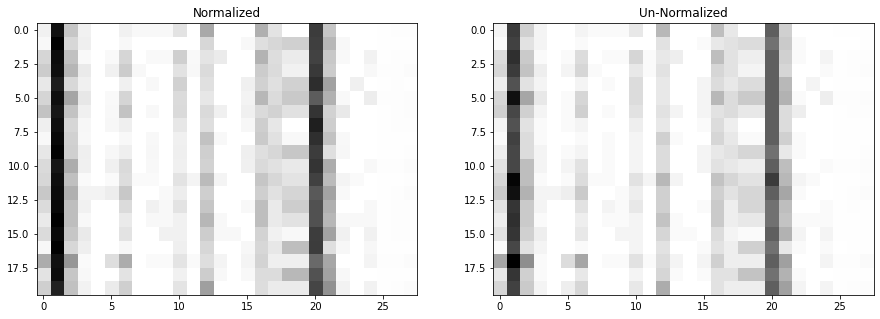

In [52]:
# Plot the "images"
plt.figure(figsize=(15,10))
plt.subplot(121)
test = tf.keras.utils.normalize([X[0].copy()])
plt.title('Normalized')
plt.imshow(test[0], cmap=plt.cm.binary)
plt.subplot(122)
plt.title('Un-Normalized')
plt.imshow(X[0], cmap=plt.cm.binary)
plt.show()
plt.close()

# Training a 2D Convnet
Now, we will beging to train a 2D convolutional network on the 'images' we just created.

In [53]:
def create_2d_convnet(window_size=10, batch_size=32, epochs=10):
    
    X, y = get_datapoints(get_schedule(), get_all_game_box_scores(), window=window_size)
    
    X = tf.keras.utils.normalize(X)
    X = np.array(X).reshape(-1, X.shape[1], X.shape[2], 1)
    
    model = Sequential()

    # Input layer
    model.add(Conv2D(64, (3,3), input_shape=X.shape[1:]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    # 2nd Layer
    model.add(Conv2D(64, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    # 3rd layer
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))

    # Output layer
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    model.fit(X,
              y,
              batch_size=batch_size,
              epochs=epochs,
              validation_split=.2)

In [54]:
create_2d_convnet(window_size=10, batch_size=64, epochs=15)


Epoch 1/15
181/181 [==============================] - 13s 69ms/step - loss: 0.6917 - accuracy: 0.5334 - val_loss: 0.6914 - val_accuracy: 0.5307
Epoch 2/15
181/181 [==============================] - 12s 69ms/step - loss: 0.6901 - accuracy: 0.5431 - val_loss: 0.6912 - val_accuracy: 0.5307
Epoch 3/15
181/181 [==============================] - 12s 69ms/step - loss: 0.6908 - accuracy: 0.5350 - val_loss: 0.6913 - val_accuracy: 0.5307
Epoch 4/15
181/181 [==============================] - 13s 69ms/step - loss: 0.6912 - accuracy: 0.5311 - val_loss: 0.6913 - val_accuracy: 0.5307
Epoch 5/15
181/181 [==============================] - 12s 69ms/step - loss: 0.6905 - accuracy: 0.5387 - val_loss: 0.6909 - val_accuracy: 0.5307
Epoch 6/15
181/181 [==============================] - 12s 69ms/step - loss: 0.6912 - accuracy: 0.5274 - val_loss: 0.6904 - val_accuracy: 0.5307
Epoch 7/15
181/181 [==============================] - 13s 70ms/step - loss: 0.6908 - accuracy: 0.5293 - val_loss: 0.6896 - val_accuracy

In [55]:
create_2d_convnet(window_size=5, batch_size=64, epochs=15)


Epoch 1/15
182/182 [==============================] - 7s 35ms/step - loss: 0.6909 - accuracy: 0.5338 - val_loss: 0.6911 - val_accuracy: 0.5317
Epoch 2/15
182/182 [==============================] - 6s 36ms/step - loss: 0.6910 - accuracy: 0.5337 - val_loss: 0.6911 - val_accuracy: 0.5317
Epoch 3/15
182/182 [==============================] - 7s 36ms/step - loss: 0.6909 - accuracy: 0.5336 - val_loss: 0.6909 - val_accuracy: 0.5317
Epoch 4/15
182/182 [==============================] - 6s 35ms/step - loss: 0.6909 - accuracy: 0.5339 - val_loss: 0.6905 - val_accuracy: 0.5317
Epoch 5/15
182/182 [==============================] - 6s 35ms/step - loss: 0.6906 - accuracy: 0.5338 - val_loss: 0.6906 - val_accuracy: 0.5317
Epoch 6/15
182/182 [==============================] - 6s 36ms/step - loss: 0.6899 - accuracy: 0.5376 - val_loss: 0.6905 - val_accuracy: 0.5317
Epoch 7/15
182/182 [==============================] - 6s 35ms/step - loss: 0.6887 - accuracy: 0.5395 - val_loss: 0.6911 - val_accuracy: 0.519

In [56]:
create_2d_convnet(window_size=7, batch_size=64, epochs=15)


Epoch 1/15
181/181 [==============================] - 9s 47ms/step - loss: 0.6919 - accuracy: 0.5253 - val_loss: 0.6914 - val_accuracy: 0.5314
Epoch 2/15
181/181 [==============================] - 8s 47ms/step - loss: 0.6909 - accuracy: 0.5354 - val_loss: 0.6912 - val_accuracy: 0.5314
Epoch 3/15
181/181 [==============================] - 9s 47ms/step - loss: 0.6909 - accuracy: 0.5347 - val_loss: 0.6905 - val_accuracy: 0.5314
Epoch 4/15
181/181 [==============================] - 9s 48ms/step - loss: 0.6901 - accuracy: 0.5366 - val_loss: 0.6906 - val_accuracy: 0.5346
Epoch 5/15
181/181 [==============================] - 9s 47ms/step - loss: 0.6904 - accuracy: 0.5352 - val_loss: 0.6896 - val_accuracy: 0.5370
Epoch 6/15
181/181 [==============================] - 9s 47ms/step - loss: 0.6883 - accuracy: 0.5429 - val_loss: 0.6900 - val_accuracy: 0.5339
Epoch 7/15
181/181 [==============================] - 9s 47ms/step - loss: 0.6885 - accuracy: 0.5373 - val_loss: 0.6895 - val_accuracy: 0.534